### **Imports and setup** 
Import packages, the config.py and architecture.py files and set global parameters

In [1]:
from config import (
    LEARNING_RATE,
    NUM_EPOCHS,
    TRAIN_SIZE,
    FP_BITS,
    FP_RADIUS,
    node_feat_list,
    edge_feat_list,
    BATCH_SIZE,
    NUM_ESTIMATORS,
)
from pkasolver.constants import SEED, DEVICE, node_feat_values, edge_feat_values
from pkasolver.data import (
    load_data,
    preprocess_all,
    train_validation_set_split,
    make_stat_variables,
    make_pyg_dataset_from_dataframe,
    calculate_nr_of_features,
    
)
from pkasolver.ml_architecture import (
    gcn_full_training,
    GCNPairSingleConv,
    GCNPairTwoConv,
    GCNProt,
    GCNDeprot,
    NNConvPair,
    NNConvDeprot,
    NNConvProt,
    GATPair, 
    GATProt, 
    GINPairV1,
    GINPairV2, 
    GINProt

)
from pkasolver.chem import generate_morgan_fp_array, calculate_tanimoto_coefficient
from pkasolver.ml import dataset_to_dataloader, test_ml_model, test_graph_model
from pkasolver.stat import compute_stats, compute_kl_divergence
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pickle

plt.rcParams["figure.figsize"] = (6.25, 6.25)
sns.set_theme(style="ticks")

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

import torch
from torch import optim
from rdkit.Chem import Draw, Mol
random.seed(SEED)
imgdir = "images_and_tables"
os.makedirs(imgdir, exist_ok=True)

num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

Setting num threads to 1
Pytorch will use cuda


In [2]:
def plot_results(results, title):
    plt.plot(results['training-set'], label='training set')
    plt.plot(results['validation-set'], label='validation set')
    if title:
        plt.title(title)
    plt.ylim([0,4])
    plt.legend()
    plt.show()

## **Data Preprocessing**

#### **Import raw data**
Load data from sdf files, create conjugate molescules and store them in pandas DataFrames

Loading data ...
dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated
536,9.7,9.63,4,basic,['chembl25'],871123,CC(C)(C)[NH2+]CC(O)c1cc(Cl)c(N)c(C(F)(F)F)c1,,

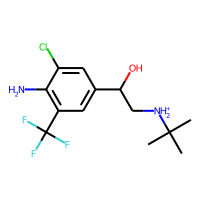
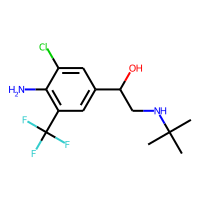

In [3]:
# make sure the directory for saving the run data exists 
# run_data stores pickle files of the dicts containing dataset-Dataframes, morgan fingerprints and pyG graphs)
run_filename = "run_data"
os.makedirs(f"{run_filename}/", exist_ok=True)

# check if saved dictonary of dataset-Dataframes is available and if so, import it
if os.path.isfile(f"{run_filename}/dataset_dfs.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/dataset_dfs.pkl", "rb") as pickle_file:
        dataset_dfs = pickle.load(pickle_file)

# create DataFrames for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    sdf_paths = load_data("../../data/Baltruschat/")
    dataset_dfs = preprocess_all(sdf_paths) # load all datasets in Dataframes and calculate protonated and deprotonated conjugates
    dataset_dfs["train_split"], dataset_dfs["val_split"] = train_validation_set_split(
        dataset_dfs["Training"], TRAIN_SIZE, SEED
    ) # take a copy of the "Training" dataset, shuffle and split it into train and validation datasets and store them as Dataframe in respective dict   

    with open(f"{run_filename}/dataset_dfs.pkl", "wb") as pickle_file:
        pickle.dump(dataset_dfs, pickle_file)

# notification
print(dataset_dfs.keys())
display(dataset_dfs["train_split"].head(1))

# **Calulate fingerprint based data**
Create Fingerprints, target-value objects and add best tanimoto similarities of fps form external validation set molecules with those of the train molecules

In [4]:
# check if saved dictonary of fingerprint data is available and if so, import it
if os.path.isfile(f"{run_filename}/fp_data.pkl"):
    with open(f"{run_filename}/fp_data.pkl", "rb") as pickle_file:
        fp_data = pickle.load(pickle_file)

# create fingerprint arrays (dim: num molecules x fp bits) for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    fp_data = {}
    for name, df in dataset_dfs.items():
        X_feat, y = make_stat_variables(df, [], ["pKa"])
        X_prot = generate_morgan_fp_array(
            df, "protonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X_deprot = generate_morgan_fp_array(
            df, "deprotonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X = np.concatenate((X_prot, X_deprot), axis=1)
        fp_data[f"{name}"] = {"prot": X_prot, "deprot": X_deprot, "pair": X, "y": y}

    with open(f"{run_filename}/fp_data.pkl", "wb") as f:
        pickle.dump(fp_data, f)

# add max tanimotosimilarity to the Dataframes of external test sets
    train_name = "train_split"
    val_name = "val_split"
    training = "Training"
    for name, dataset in fp_data.items():
        if name in [train_name, val_name, training]:
            pass
        else:
            print(f"calculating similarities for {name}")
            max_scores = []
            for test_mol in dataset["prot"]:
                scores = []
                for ref_mol in fp_data[train_name]["prot"]:
                    scores.append(calculate_tanimoto_coefficient(test_mol, ref_mol))
                max_scores.append(max(scores))
            dataset_dfs[name]["Similarity_max"] = max_scores

with open(f"{run_filename}/dataset_dfs.pkl", "wb") as f:
    pickle.dump(dataset_dfs, f)

# notification
print("fp_data keys:", fp_data.keys())
print(f"calculated/loaded fingerprint data successfully")

fp_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded fingerprint data successfully


# **Calculate graph data**
Create graph data with node and edge features specified in the config file and prepare loaders

In [5]:
# check if saved dictonary of graph data is available and if so, import it
if os.path.isfile(f"{run_filename}/graph_data.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/graph_data.pkl", "rb") as f:
        graph_data = pickle.load(f)

# create list of 'PairData' graph objects for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    graph_data = {}
    for name, df in dataset_dfs.items():
        print(f"Generating data for: {name}")
        graph_data[name] = make_pyg_dataset_from_dataframe(
            df, node_feat_list, edge_feat_list, paired=True
        )
    with open(f"{run_filename}/graph_data.pkl", "wb") as f:
        pickle.dump(graph_data, f)

print("graph_data keys:", graph_data.keys())

# create an iterable loader object from the list of graph data of each dataset and store them in a dictonary
loaders = {}
for name, dataset in graph_data.items():
    print(f"Generating loader for {name}")
    if name == "Training":
        print("Skipping unsplit Training dataset")
        continue
    elif name == "train_split" or name == "val_split":
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=True) # Shuffling is essential to avoid overfitting on particular batches
    else:
        loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=False) # Testsets must not be shuffled in order to be able to calculate per datapoint predcitons with all graph and baselinemodels in the analysis part

# notification
print("loaders keys:", loaders.keys())
print(f"calculated/loaded graph data successfully")

Loading data ...
graph_data keys: dict_keys(['Training', 'Novartis', 'Literature', 'train_split', 'val_split'])
Generating loader for Training
Skipping unsplit Training dataset
Generating loader for Novartis
Generating loader for Literature
Generating loader for train_split
Generating loader for val_split
loaders keys: dict_keys(['Novartis', 'Literature', 'train_split', 'val_split'])
calculated/loaded graph data successfully


In [6]:
from config import node_feat_values
pd.set_option('display.max_columns', None)
def color_positive_red(val):
    color = 'red' if val > 0 else 'black'
    return 'color: %s' % color

lst = graph_data['Novartis'][1].x_p


node_feat_names = []
for feat in node_feat_list:
    values = node_feat_values[feat]
    for value in values:
        node_feat_names.append(f'{feat} = {value}')

df = pd.DataFrame(lst, columns= node_feat_names, dtype=int)
df.style.applymap(color_positive_red)

,element = 1,element = 6,element = 7,element = 8,element = 9,element = 15,element = 16,element = 17,element = 33,element = 35,element = 53,formal_charge = -1,formal_charge = 0,formal_charge = 1,hybridization = 1,hybridization = 2,hybridization = 3,hybridization = 4,total_num_Hs = 0,total_num_Hs = 1,total_num_Hs = 2,total_num_Hs = 3,aromatic_tag = 1,total_valence = 1,total_valence = 2,total_valence = 3,total_valence = 4,total_valence = 5,total_valence = 6,total_degree = 1,total_degree = 2,total_degree = 3,total_degree = 4,is_in_ring = 1,reaction_center = 1,smarts = -OSO3H,smarts = –SO3H,smarts = -OSO2H,smarts = -SO2H,smarts = -OPO3H2,smarts = -PO3H2,smarts = -CO2H,smarts = thiophenol,smarts = (-OPO3H)-,smarts = (-PO3H)-,smarts = phthalimide,smarts = CO3H (peracetyl),smarts = alpha-carbon-hydrogen-nitro group,smarts = -SO2NH2,smarts = -OBO2H2,smarts = -BO2H2,smarts = phenol,smarts = SH (aliphatic),smarts = (-OBO2H)-,smarts = (-BO2H)-,smarts = cyclopentadiene,smarts = -CONH2,smarts = imidazole,smarts = -OH (aliphatic alcohol),smarts = alpha-carbon-hydrogen-keto group,smarts = alpha-carbon-hydrogen-acetyl ester group,smarts = sp carbon hydrogen,smarts = alpha-carbon-hydrogen-sulfone group,smarts = alpha-carbon-hydrogen-sulfoxide group,smarts = -NH2,smarts = benzyl hydrogen,smarts = sp2-carbon hydrogen,smarts = sp3-carbon hydrogen,smarts = Hydrogen-bond acceptor,smarts = Hydrogen-bond donor,smarts = Possible intramolecular H-bond
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


**show feature value range**

In [7]:
# # print all possible node feature values
# values = [set() for i in range(len(node_feat_list))]
# for dataset in graph_data.values():
#     for entry in dataset:
#         for i, row in enumerate(entry.x_p.cpu().T):
#             values[i] = values[i] | set(row.numpy())
#         for i, row in enumerate(entry.x_d.cpu().T):
#             values[i] = values[i] | set(row.numpy())
# print("Node features:")
# for name, values in zip(node_feat_list, values):
#     x = list(values)
#     x.sort()
#     print(f"{name}:{x}")
# print("\n")

# # print all possible edge feature values
# values = [set() for i in range(len(edge_feat_list))]
# for dataset in graph_data.values():
#     for entry in dataset:
#         for i, row in enumerate(entry.edge_attr_p.cpu().T):
#             values[i] = values[i] | set(row.numpy())
#         for i, row in enumerate(entry.edge_attr_d.cpu().T):
#             values[i] = values[i] | set(row.numpy())
# print("Edge features:")
# for name, values in zip(edge_feat_list, values):
#     x = list(values)
#     x.sort()
#     print(f"{name}:{x}")



# **Training of predictive models**

## **train baseline models**
train all baseline models in protonated, deprotonated and pair mode

In [8]:
models_dict = {
    "RFR": RandomForestRegressor(
        n_estimators=NUM_ESTIMATORS, random_state=SEED
    ),  # Baltruschat n_estimatores = 1000
    "PLS": PLSRegression(),
}

baseline_models = {}
train_name = "train_split"
val_name = "val_split"

for model_name, model_template in models_dict.items():
    baseline_models[model_name] = {}
    for mode, X in fp_data[train_name].items():
        if mode == "y":
            continue
        path = f"models/baseline/{model_name}/{mode}/"
        if os.path.isfile(path + "model.pkl"):
            with open(path + "model.pkl", "rb") as pickle_file:
                baseline_models[model_name][mode] = pickle.load(pickle_file)
        else:
            print(f"Training {model_name}_{mode}...")
            y = fp_data[train_name]["y"]
            y_val = fp_data[val_name]["y"]
            model = copy.deepcopy(model_template)
            model.fit(X, y)
            print(f"{model_name}_{mode}: {model.score(fp_data[val_name][mode], y_val)}")
            baseline_models[model_name][mode] = model
            os.makedirs(path, exist_ok=True)
            with open(path + "model.pkl", "wb") as pickle_file:
                pickle.dump(model, pickle_file)
print(f"trained/loaded baseline models successfully")

trained/loaded baseline models successfully


# **Train graph models**

## **Training**
train all graph models in protonated, deprotonated and pair mode

In [9]:
from pkasolver.ml_architecture import GINProt, GINPairV1,GINPairV2, AttentiveProt
NUM_EPOCHS = 40

models = [('GCNPairSingleConv', GCNPairSingleConv), 
('GCNPairTwoConv', GCNPairTwoConv), 
('GCNProt', GCNProt), 
('GCNDeprot', GCNDeprot), 
('NNConvPair', NNConvPair), 
('NNConvDeprot', NNConvDeprot), 
('NNConvProt', NNConvProt )]

# models = [("AttentiveProt", AttentiveProt), ("GINPairV2", GINPairV2), ("GINPairV1", GINPairV1), ]


for model_name, model_class in models:
    path = f"models/gcn/"
    os.makedirs(path, exist_ok=True)
    pkl_file_name = f"{path}/{model_name}.pkl"
    if os.path.isfile(pkl_file_name):
        print('Attention: RELOADING model')
        with open(pkl_file_name, "rb") as pickle_file:
            model = pickle.load(pickle_file)
    else:
        model = model_class(num_node_features, num_edge_features, hidden_channels = 32)

    if model.checkpoint["epoch"] < NUM_EPOCHS:
        model.to(device=DEVICE)
        print(model.checkpoint["epoch"])
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print("Number of parameters: ", sum(p.numel() for p in model.parameters()))            
        try:
            optimizer.load_state_dict(model.checkpoint["optimizer_state"])
        except:
            pass
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, verbose=True
        )

        print(
            f'Training {model_name} at epoch {model.checkpoint["epoch"]} ...'
        )
        print(f'LR: {LEARNING_RATE}')
        print(model_name)
        print(model)
        print(f'Training on {DEVICE}.')
        results = gcn_full_training(
            model.to(device=DEVICE),
            loaders["train_split"],
            loaders["val_split"],
            optimizer,
            pkl_file_name,
            NUM_EPOCHS,
        )

        plot_results(results, f'{model_name}')
        with open(f"{path}/{model_name}.pkl", "wb") as pickle_file:
            pickle.dump(model.to(device='cpu'), pickle_file)
print(f"trained/loaded gcn models successfully")

Attention: RELOADING model
Attention: RELOADING model
Attention: RELOADING model
Attention: RELOADING model
Attention: RELOADING model
Attention: RELOADING model
Attention: RELOADING model
trained/loaded gcn models successfully


In [10]:
graph_models = {}
for model_name, model_class in models:
    path = f"models/gcn/"
    os.makedirs(path, exist_ok=True)
    pkl_file_name = f"{path}/{model_name}.pkl"
    if os.path.isfile(pkl_file_name):
        with open(pkl_file_name, 'rb') as pickle_file:
            model = pickle.load(pickle_file)
        model.to(device='cpu')
        best_loss = max([x for x in model.checkpoint['best_states'].keys() if x < 4_000]) 
        model.load_state_dict(model.checkpoint['best_states'][best_loss][1])
        loss = model.checkpoint['best_states'][best_loss][0]
        print(f'{model_name},Epoch {best_loss}, Loss:{loss}')
        graph_models[model_name] = model
    else:
        print(f'{path} not found')

GCNPairSingleConv,Epoch 40, Loss:1.225
GCNPairTwoConv,Epoch 40, Loss:0.931
GCNProt,Epoch 40, Loss:1.038
GCNDeprot,Epoch 40, Loss:1.058
NNConvPair,Epoch 20, Loss:2.482
NNConvDeprot,Epoch 40, Loss:3.318
NNConvProt,Epoch 20, Loss:3.174


In [11]:
#Predictions of baseline and graph models

for i,test_set in enumerate(['Novartis', 'Literature', 'val_split']):

    df_ml = test_ml_model(baseline_models, fp_data[test_set], fp_data[test_set]['y'],test_set)
    df_gcn = test_graph_model(graph_models, loaders[test_set],test_set)
    df= pd.concat([df_ml.drop(columns=['Dataset', 'pKa_true']),df_gcn],axis=1)
    df= pd.concat([df_gcn],axis=1)
    torch.cuda.empty_cache()
    if i == 0:
        df_res = df
    else:
        df_res = pd.concat([df_res,df])
display(df_res)

,Dataset,pKa_true,GCNPairSingleConv,GCNPairTwoConv,GCNProt,GCNDeprot,NNConvPair,NNConvDeprot,NNConvProt
0,Novartis,8.55,6.046066,7.526530,7.898062,6.756680,5.427408,3.422254,4.338609
1,Novartis,5.50,5.643606,6.861132,7.336844,6.695265,4.500665,3.386633,3.919191
2,Novartis,4.50,5.632803,6.862024,7.343757,6.675804,4.435431,3.334055,3.840724
3,Novartis,5.50,5.607701,6.959702,7.368056,6.624238,4.529641,3.495664,3.959824
4,Novartis,5.00,5.529532,6.724491,7.242221,6.594652,4.357677,3.294581,3.783647
...,...,...,...,...,...,...,...,...,...
1194,val_split,7.00,3.905316,6.807816,9.313117,10.129478,3.754266,4.455156,4.857893
1195,val_split,5.65,5.650054,11.181784,7.406839,7.322483,6.239978,3.299068,3.096960
1196,val_split,8.20,8.155204,4.670282,9.322206,6.927880,3.182133,5.322993,3.264717
1197,val_split,7.60,6.620819,4.685668,6.690197,4.611045,2.347204,5.221660,4.399455


In [12]:
test= compute_stats(df_res, 'Dataset', 'pKa_true')
test.to_csv(f'{imgdir}/stat_metrics.csv')
display(test)

Novartis               Literature               val_split  \
                       R^2   RMSE    MAE        R^2   RMSE    MAE       R^2   
GCNPairSingleConv    0.504  1.621  1.270      0.637  1.421  1.216    -0.629   
GCNPairTwoConv       0.532  1.576  1.260      0.773  1.123  0.847    -0.754   
GCNProt              0.411  1.767  1.430      0.724  1.240  0.839    -0.720   
GCNDeprot            0.466  1.684  1.378      0.703  1.286  1.023    -0.588   
NNConvPair          -0.101  2.416  1.921     -0.580  2.966  2.671    -1.393   
NNConvDeprot        -1.092  3.332  2.839     -1.837  3.974  3.654    -2.093   
NNConvProt          -0.863  3.144  2.684     -1.535  3.757  3.448    -1.161   

                                 
                    RMSE    MAE  
GCNPairSingleConv  3.054  2.515  
GCNPairTwoConv     3.169  2.591  
GCNProt            3.138  2.577  
GCNDeprot          3.015  2.450  
NNConvPair         3.702  3.068  
NNConvDeprot       4.209  3.548  
NNConvProt         3.518  3.177

Plot best model
Plot the predictions of the best models for the validation and the two testsets

In [13]:
# def plot_results(df, x_column, y_column):
#     y = df[x_column]
#     y_hat = df[y_column]
#     stat_info = f"""
#         $r^2$ = {r2_score(y, y_hat): .2f}
#         $MAE$ = {mean_absolute_error(y, y_hat): .2f}
#         $RMSE$ = {mean_squared_error(y, y_hat): .2f}
#         """
#         # r² = 0.78 [0.74, 0.81]
#     g = sns.JointGrid(data=df, x=x_column, y=y_column, xlim=(2,12), ylim=(2,12), height=3.125)
#     g.plot_joint(sns.regplot)
#     g.plot_marginals(sns.kdeplot, shade=True)
#     g.ax_joint.text(0, 1, stat_info, size='x-small', ha='left', va="top", transform = g.ax_joint.transAxes)
#     return g

def plot_results(df, x_column, y_column):
    y = df[x_column]
    y_hat = df[y_column]
    stat_info = f"""
        $r^2$ = {r2_score(y, y_hat): .2f}
        $MAE$ = {mean_absolute_error(y, y_hat): .2f}
        $RMSE$ = {mean_squared_error(y, y_hat): .2f}
        $kl_div$ = {compute_kl_divergence(y_hat,y): .2f}
        """
        # r² = 0.78 [0.74, 0.81]
    g = sns.JointGrid(data=df, x=x_column, y=y_column, xlim=(2,12), ylim=(2,12), height=3.125)
    g.plot_joint(sns.regplot)
    
    g.plot_marginals(sns.kdeplot, shade=True)
    g.ax_joint.text(0, 1, stat_info, size='x-small', ha='left', va="top", transform = g.ax_joint.transAxes)
    return g

/data/shared/projects/pKa-prediction/anaconda3/envs/pkasolver/lib/python3.9/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


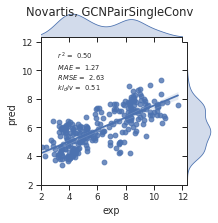

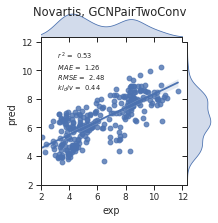

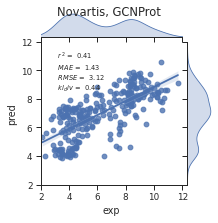

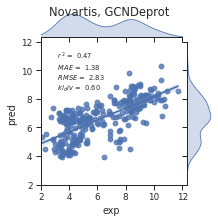

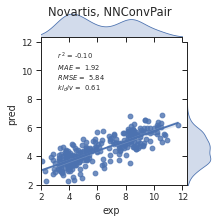

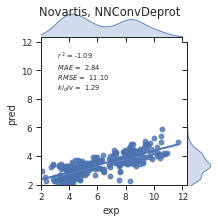

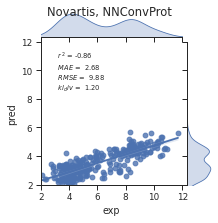

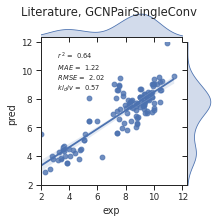

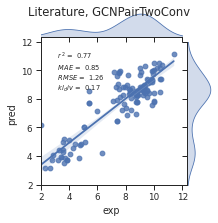

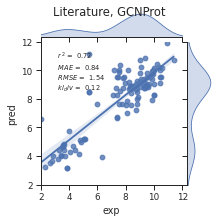

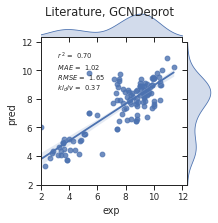

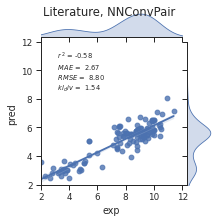

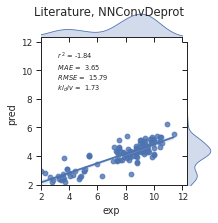

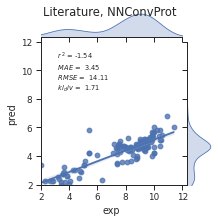

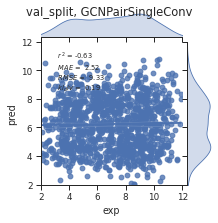

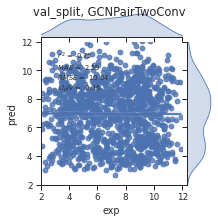

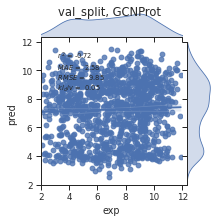

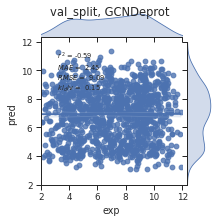

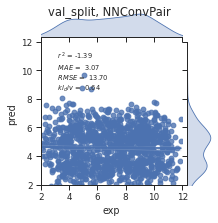

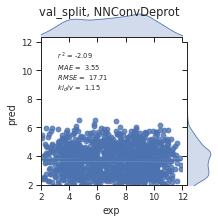

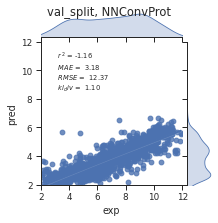

In [14]:
sns.set_context('paper')
d = df_res
# model='GCN_prot_edge'
for dataset in d['Dataset'].unique():
    for model in df.columns.drop(["pKa_true", "Dataset"]):
# for dataset, model in zip(['Novartis','Literature'],['GCN_pair_edge', 'GCN_deprot_no-edge']):
        g = plot_results(d[d['Dataset']== dataset], 'pKa_true', model)
        g.set_axis_labels('exp', 'pred')
        g.fig.suptitle(f'{dataset}, {model}')
        plt.savefig(f'{imgdir}/regression_{dataset}_{model}.pdf', bbox_inches='tight')

GCN training progress

store training losses in DataFrame and

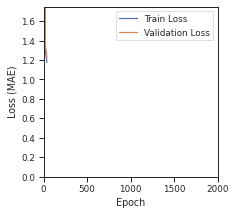

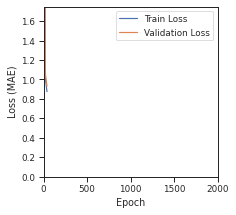

In [15]:
for m in list(["GCNPairSingleConv","GCNPairTwoConv"]):
    df_prog=pd.DataFrame(graph_models[m].checkpoint['progress_table'])
#     df_prog=pd.DataFrame(graph_models_cv[x][y][1].checkpoint['progress_table'])
    #plot learning
    fig, ax = plt.subplots()
    fig.set_size_inches(3.125,3.125)
    sns.lineplot(x='epoch',y='train_loss', label='Train Loss',data=df_prog,ax=ax)
    sns.lineplot(x='epoch',y='validation_loss',label='Validation Loss',data=df_prog,ax=ax)
    ax.set_ylabel("Loss (MAE)")
    ax.set_xlabel("Epoch")
    ax.set_xlim(left=0, right=2000)
    ax.set_ylim(top=1.75, bottom=0)
#     plt.title(f'training progress of gcn_{x}_{y} model')
    plt.savefig(f'{imgdir}/training_progress_gcn_{m}.pdf',bbox_inches='tight')
    plt.show()


Feature impact

Importances of gcn_prot_edge'

In [16]:
# def boxplot(attr_data):
#     plt.figure(figsize=(3.125,6.25))
#     sns.boxplot(x="value", y="variable",
#                 orient="h",
#                 data=attr_data,
#                 whis=[0, 100], width=.6)

#     # Add in points to show each observation
#     sns.stripplot(x="value", y="variable",
#                 orient="h",
#                 data=attr_data,
#                 size=4, color=".3", linewidth=0)
#     plt.ylabel('')

# # types = ['prot','deprot','pair']
# types = ['prot']
# f_modes= ['no-edge','edge']
# for data_type in types:
#     for f_mode in f_modes: 
#         model = graph_models[data_type][f_mode]
#         dataset = graph_data['train_split']
#         ig = IntegratedGradients(model)
#         attr_pre_df = calc_importances(ig, dataset, 100, list_node_features, list_edge_features) #adjust number of random samples

#         attr_pre_df.iloc[:, 1:]=attr_pre_df.iloc[:, 1:].abs()
#         attr_df=attr_pre_df.groupby('ID').max()
#         attr_data = pd.melt(attr_df)
        
#         if data_type== 'pair':
#             split = len(attr_data.variable.unique())//2
#             attr_data1 = pd.melt(attr_df.iloc[:,0:split])
#             attr_data2 = pd.melt(attr_df.iloc[:,split:])
        
#             boxplot(attr_data1)
# #             plt.title(f'gcn_{data_type}_1_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_1_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()
#             boxplot(attr_data2)
# #             plt.title(f'gcn_{data_type}_2_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_2_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()
            
#         else:
#             boxplot(attr_data)
# #             plt.title(f'gcn_{data_type}_{f_mode}')
#             plt.savefig(f'{imgdir}/importances_{data_type}_{f_mode}.pdf', bbox_inches='tight')
#             plt.show()

Metrics by tanimoto similarity

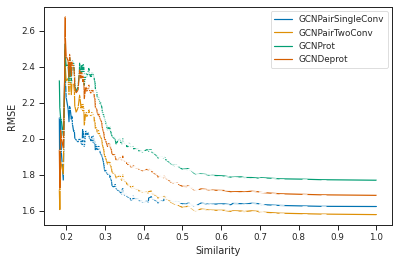

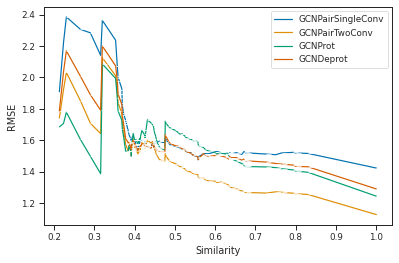

In [17]:
x1= pd.concat([df_res[['Dataset', 'pKa_true']],df_res.loc[:,(df_res.columns.str.startswith('GCN'))]],axis=1)
for data_set in ['Novartis', 'Literature']:
    df = x1[x1['Dataset']==data_set].copy()
    df['similarity'] = dataset_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)

    res=[]
    tanimoto=[]
    maximum=0

    for i in range(2,len(df)):
        df2 = df.iloc[:i,:]
        new_maximum = df2['similarity'].max()
        if new_maximum <= maximum:
            tanimoto[-1]= new_maximum
            res[-1]= compute_stats(df2, 'Dataset', 'pKa_true',col_exclude=['similarity'])
        else: 
            tanimoto.append(new_maximum)
            res.append(compute_stats(df2, 'Dataset', 'pKa_true', col_exclude=['similarity']))
        maximum=new_maximum
    result = pd.concat((res), keys=tanimoto)
    result

    # X=result['Novartis'].loc[(slice(None),'pKa_gcn_prot_edge'),:].reset_index()
    X=result[data_set].reset_index()
    plt.figure(figsize=(6.25,4))
    # ax = sns.scatterplot(x='level_0', y="RMSE", hue='level_1', palette='colorblind', data=X)
    ax = sns.lineplot(x='level_0', y="RMSE", hue='level_1', marker=True, palette='colorblind', data=X)
    legend = ax.legend()
    legend.texts[0] = ''
    
    plt.xlabel('Similarity')
    plt.savefig(f'{imgdir}/RMSE_sim_{data_set}.pdf')
    
    x2= x1
    df = x2[x2['Dataset']==data_set].copy()
    df['similarity'] = dataset_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)
    
    df = df.loc[:,('pKa_true','GCNPairTwoConv','similarity')]

    df['Error']= df['GCNPairTwoConv']-df['pKa_true']

    # sims=[]
    # step_size=0.15
    # for sim in df['similarity']:
    #     x=1
    #     while sim < x:
    #         x+= -step_size
    #     sims.append(f'< {round(np.clip(x+step_size,0,1),3)}')
    # df['group']=sims            

    # plt.figure(figsize=(6.25/2,2.5))
    # sns.boxplot(x="group", y="Error",
    #             orient="v",

    #             whis=[0, 100], width=.6,
    #             data=df
    #            )
    # # Add in points to show each observation
    # sns.stripplot(x="group", y="Error",
    #             orient="v",
    #             data=df,
    #               size=4, color=".3", linewidth=0)
    # plt.xlabel('Similarity')
    # plt.ylabel('Error [pKa units]')
    # plt.savefig(f'{imgdir}/error_sim_bloxplot_{data_set}.pdf', bbox_inches='tight')


Outliers top list

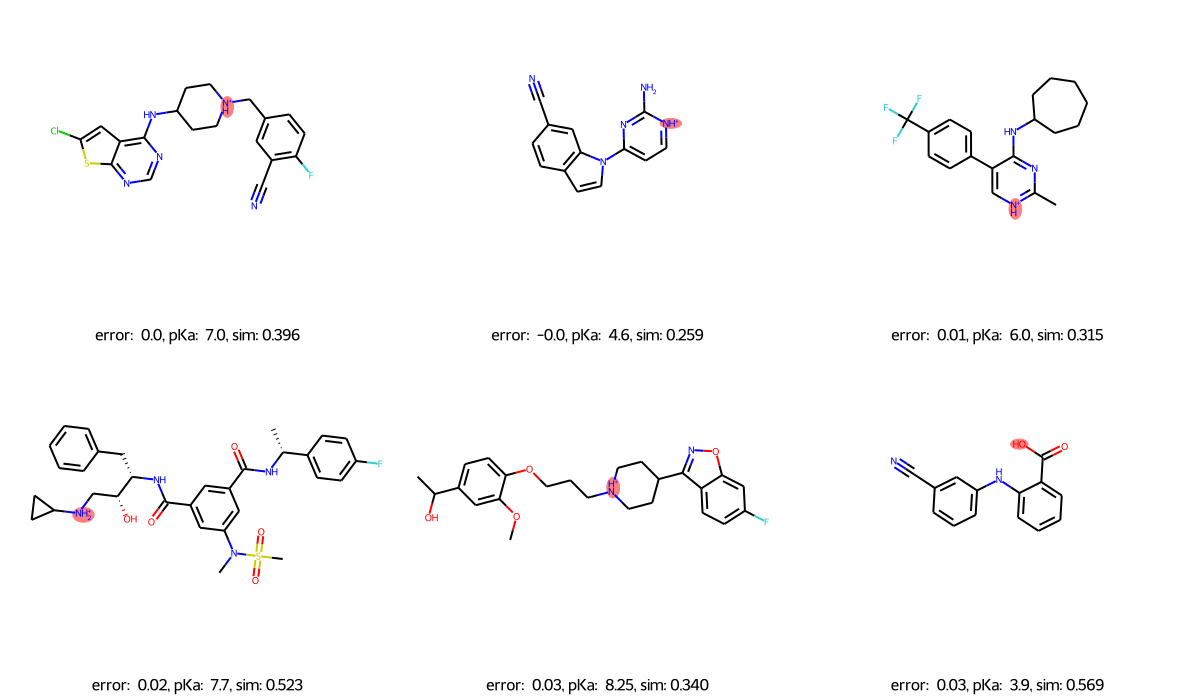

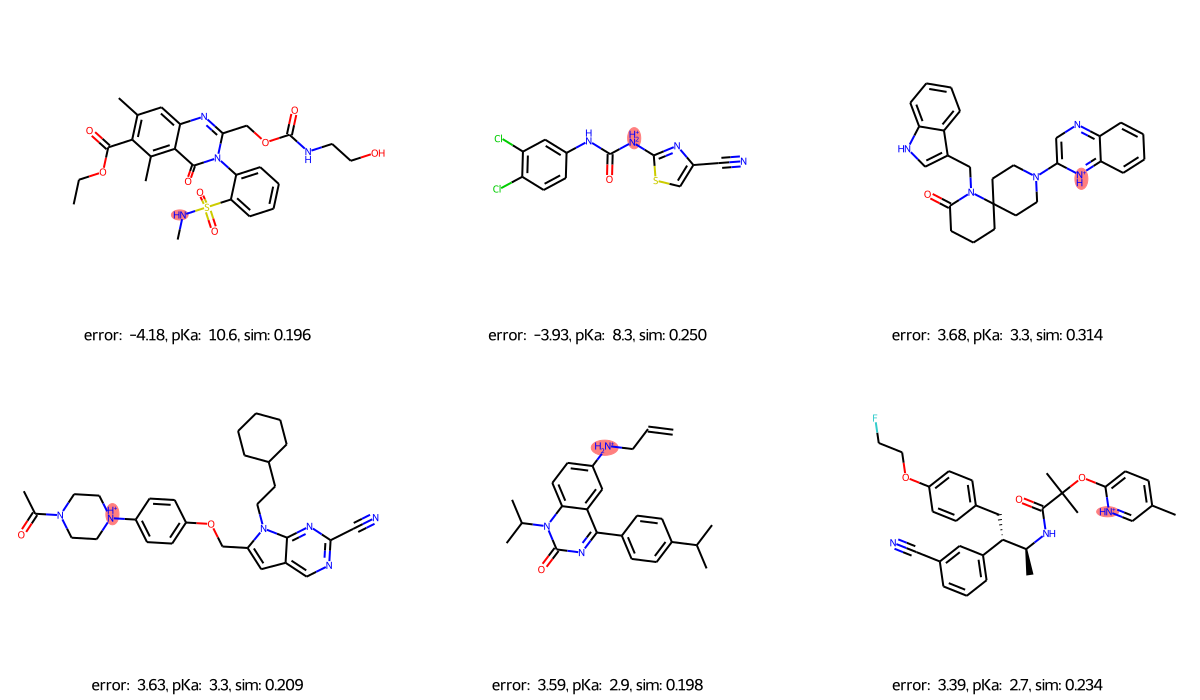

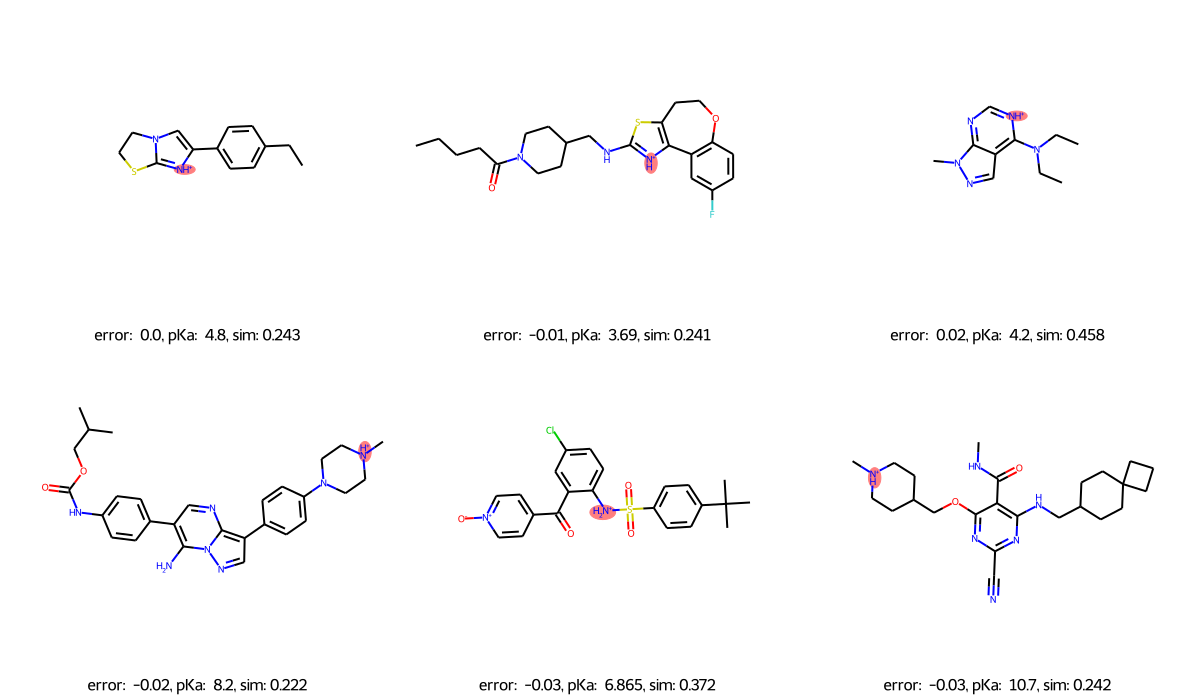

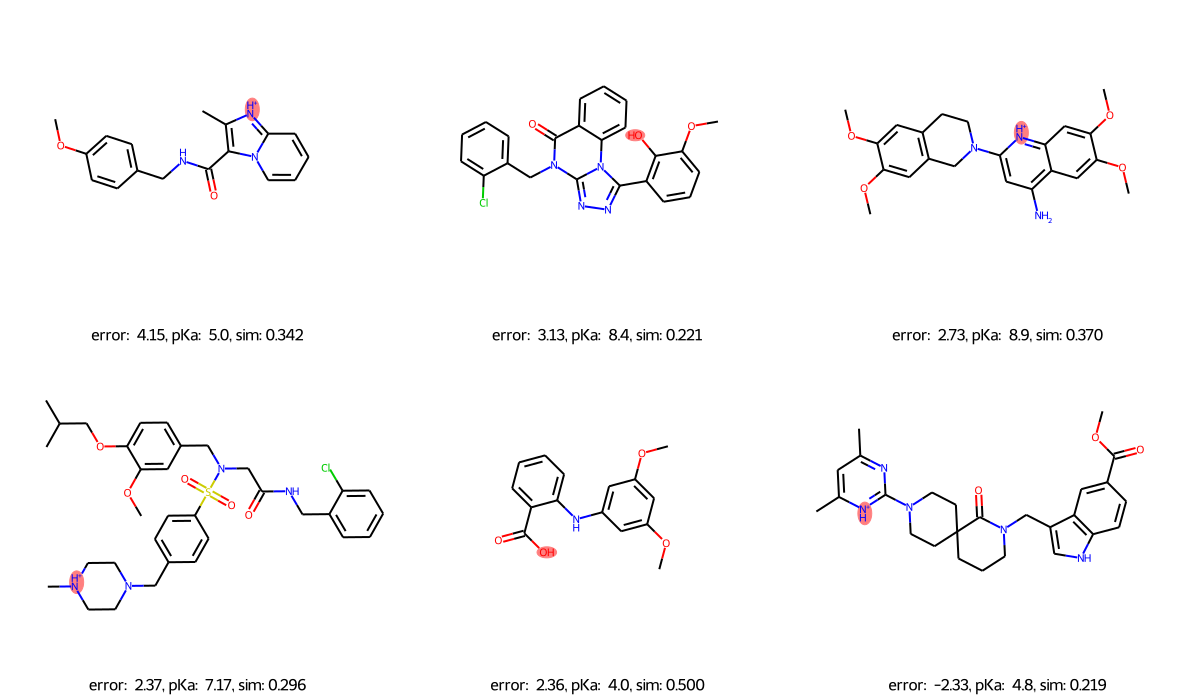

In [18]:
def get_2d_molecule(m):
  copy = Mol(m)
  copy.Compute2DCoords(clearConfs=True)
  return copy

def group_by_range(series, range_list, decimal=1):
    group_labels=[]
    for x in series:
        i=0
        while x > range_list[i]:
            i+=1
        group_labels.append(round(range_list[i],decimal))
    return group_labels 

data_set=['Novartis', 'Literature']
best=[True, False]
for data_set in data_set:
    trues= df_res[df_res.Dataset==data_set].pKa_true
    preds= df_res[df_res.Dataset==data_set].GCNPairTwoConv
    diffs = []
    errors = []
    for pred, true in zip(preds,trues):
        diffs.append(pred-true)
        errors.append(abs(pred-true))
    res = pd.concat((pd.DataFrame({'differences':diffs}),pd.DataFrame({'errors':errors}), dataset_dfs['Novartis'].loc[:,('pKa','marvin_atom','protonated', 'deprotonated', 'ID','Similarity_max')]),axis=1)
    
    res_e=res.loc[:, ('errors','pKa','Similarity_max')]
    res_e['pKa']=group_by_range(res_e['pKa'],list(range(2,14,2)))
    res_e['Similarity']=group_by_range(res['Similarity_max'],np.arange(0.0,1.2,0.2))
    res_e=res_e.loc[:, ('errors','pKa','Similarity')]
    res_e=res_e.groupby(['Similarity','pKa']).mean().unstack()
#     display(res_e)
    
    # plt.figure(figsize=(3.125,2.5))
    # sns.heatmap(res_e['errors'], cmap='RdYlGn_r', vmin=0,vmax=1.50)
    # plt.savefig(f'{imgdir}/error_heatmap_{data_set}.pdf', bbox_inches='tight')
    # plt.show()
    
    for mod in best:    
        res.sort_values(by=['errors'], inplace=True, ascending=mod)
        num=6
        img=Draw.MolsToGridImage(res.protonated[:num].map(get_2d_molecule),
                                 molsPerRow=3,
                                 subImgSize=(400,350),
                                 useSVG=True,
                                 highlightAtomLists=[[int(i)] for i in res.marvin_atom[:num]],
                                 legends=[f"error:  {round(x[1],2)}, pKa:  {x[0]}, sim: {x[2]:.3f}" for x in zip(res.pKa[:num],res.differences[:num], res.Similarity_max[:num])])

        display(img)
        name_dict={True:'best',False:'outlier'}
        with open(f'{imgdir}/grid_{data_set}_{name_dict[mod]}.svg', 'w') as f:
            f.write(img.data)
    # res.head()